In [1]:
from IPython.display import HTML

HTML('''<script>
code_hide=true; 
function code_toggle() {
 if (code_hide){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_hide = !code_hide
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Por defecto el código está oculto. Clickear acá para mostrar/ocultar código."></form>''')

In [ ]:
# SOLO PARA CORRER EN COLAB DDE GH
!git clone https://github.com/tvillani22/PSeI.git # Master
import sys
import os
sys.path.append('/content/PSeI/')
os.chdir('PSeI/')

In [2]:
import numpy as np
import scipy.fft as fft
import scipy.signal as ss
import scipy.ndimage as si
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as tck
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
import PIL.Image
from IPython import display
mpl.rcParams['axes.titlesize']=13
style = {'axes.facecolor': 'whitesmoke','axes.grid':True}
bpp = {'L': ['Escala de grises', 8], 'RGB': ['Truecolor', 24], 'RGBA': ['Deepcolor', 32]}

***
<h1 style="color:black;font-size:40px"><center>MÓDULO 4</center></h1>

***
***

# 4.2 Actividad 10

***
>***b) En el programa que uses habitualmente, hacé la misma operación haciendo uso de alguna función del lenguaje (conv2 y/o imfilter en Octave/Matlab).<br> 
En caso que exista alguna diferencia respecto del resultado que obtuviste antes con tu cálculo "a lápiz y papel", comentala en el foro y explicala.***
***

***Creo las matrices...***

In [3]:
A = np.zeros((5,5))
A[1,2], A[2,1], A[2,2], A[2,3], A[3,2] = 4, 1, 2, 3, 5 
W = np.zeros((3,3))
W[1,2]=1
print(A, '\n')
print(W)

[[0. 0. 0. 0. 0.]
 [0. 0. 4. 0. 0.]
 [0. 1. 2. 3. 0.]
 [0. 0. 5. 0. 0.]
 [0. 0. 0. 0. 0.]] 

[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]


***Las convoluciono...***

In [4]:
ss.convolve(A, W, mode='same')

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 4., 0.],
       [0., 0., 1., 2., 3.],
       [0., 0., 0., 5., 0.],
       [0., 0., 0., 0., 0.]])

***Se observa que la convolición con una delta desplazada una cierta magnitud desplaza la matriz/función original en esa magnitud, lo cual tiene sentido con lo propiedad general de la delta...***
$$
x[n]*\delta[n-n_0] = x[n-n_0] 
$$

***Mecánicamente esto ocurre porque la convolución, a diferencia de la correlación, implica una rotación de 180$^\circ$ del kernel.*** 

***
***

# 4.3 Actividad 11

>***Aplicar a una imagen<br>
-un filtro suavizante<br>
-un filtro laplaciano***

>***Luego:<br>
>a) Comparar las imágenes antes y después del filtrado. Describir los efectos en el dominio espacial.<br>
b) Comparar los espectros de magnitud de las imágenes antes y después del filtrado. Describir los efectos observados en el dominio frecuencial.<br>
c) ¿se te ocurre alguna estrategia para logar tener una imagen con los bordes realzados, pero no solamente los bordes? ¿Cuál podría ser el filtro que devuelva una imagen con esas características?***

***Abro la imagen y miro qué tipo de dato es...*** 

In [5]:
# Creo una función para abrir la imagen y la prof de bits..
def abrir(file):
    img = mpl.image.imread(file)
    print('Tipo de dato:', img.dtype)
    bd = int(img.nbytes*8/img.size)
    return img, bd
img, bd = abrir('Data/Torax.bmp')

Tipo de dato: uint8


***Aplico filtro suavizante de promedio simple...***

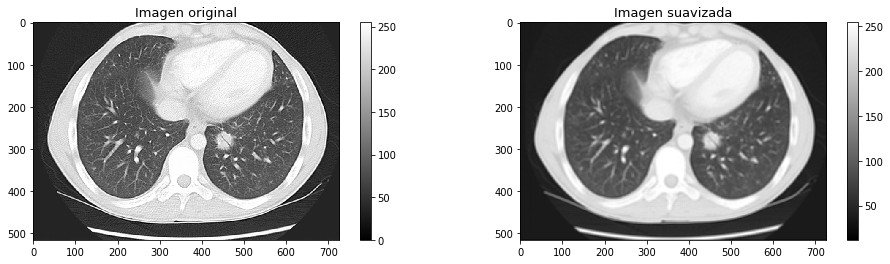

In [6]:
# Filtro suavizante...
N = 7 # dimensión del filtro
FS = np.ones((N,N))*1/N**2

# Convoluciono..
img_s = ss.convolve(img, FS, mode='same');

# Creo una función para visualizar imágenes o espectros..
mi_fft = lambda f: abs(fft.fftshift(fft.fft2(f)))
def visualizar(imgs, tit_b_2, tit_b_1=['original'], vmax=None, frec=False):
    ncols = len(imgs)
    fig, ax = plt.subplots(1, ncols, figsize=(ncols*8,4))
    if frec:
        imgs = [np.log10(mi_fft(im) + 1) for im in imgs]
        tit_a = 'Log del espectro de magnitud\nde imagen '
    else:
        tit_a = 'Imagen '
    for axx, im, tit_b in zip(ax, imgs, tit_b_1 + tit_b_2):
        cb = axx.imshow(im, cmap='gray', vmax=vmax)
        axx.set(title=tit_a + tit_b)
        fig.colorbar(cb, ax=axx)
    return

# Visualizo..
visualizar([img, img_s], ['suavizada'])

***Usando una función de `scipy`...***

In [7]:
img_s2 = si.uniform_filter(img.astype(np.float64), N, mode='constant')
print('La imagen suavizada es igual: ', np.allclose(img_s, img_s2))

La imagen suavizada es igual:  True


***Mirando el espectro de magnitud...***

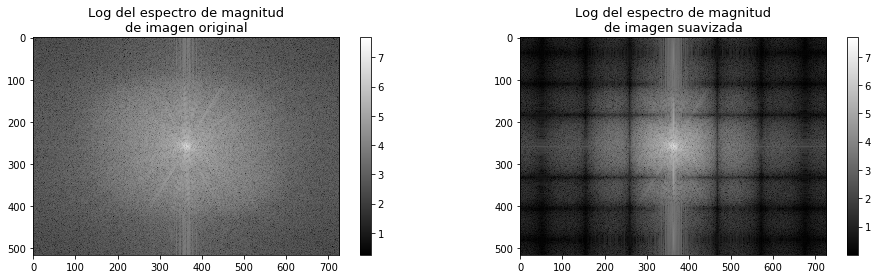

In [8]:
visualizar([img, img_s], ['suavizada'], frec=True)

***
***Aplico filtro suavizante gaussiano...***

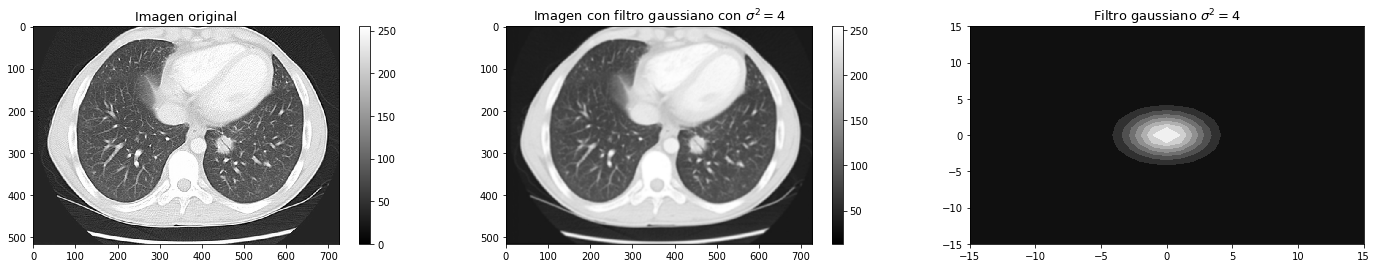

In [9]:
N =  30 # dimensión del filtro
N_ = N//2

# Secuencia de filtros suavizantes con desvios decrecientes..
for de in np.append(np.logspace(3,-2,6), 4):
    # Creo filtro gaussiano
    x, y = np.meshgrid(np.arange(-N_,N_+1), np.arange(-N_,N_+1))
    FS_g = st.multivariate_normal(mean=[0,0], cov=de).pdf(np.dstack((x, y)))
    plt.pause(0.2)
    display.clear_output(wait=True)
    
    # Convoluciono y visualizo mostrando el filtro utilizado..
    img_sg = ss.convolve(img, FS_g, mode='same');
    visualizar([img, img_sg,[]], ['con filtro gaussiano con $\sigma^2 = {:.1g}$'.format(de)] )
    ax_ = plt.gca()
    ax_.contourf(x, y, FS_g, cmap='gray')
    ax_.set(title='Filtro gaussiano $\sigma^2 = {:.1g}$'.format(de))

***Usando una función de `scipy`...***

La imagen suavizada es igual:  True


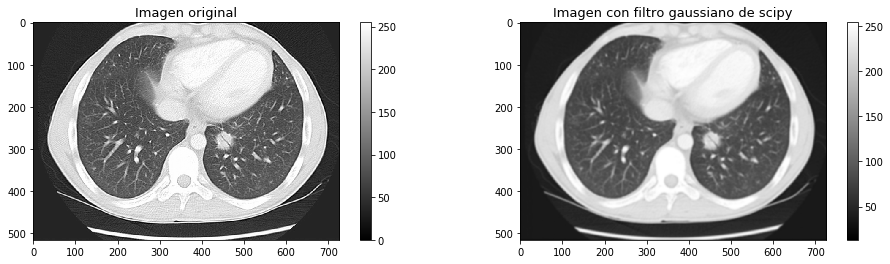

In [12]:
img_sg2 = si.gaussian_filter(img.astype(np.float64), sigma=de**(1/2), mode='constant')
visualizar([img, img_sg2], ['con filtro gaussiano de scipy'])
print('La imagen suavizada es igual: ', np.allclose(img_sg, img_sg2, atol=1e-2))

***Miro el espectro...***

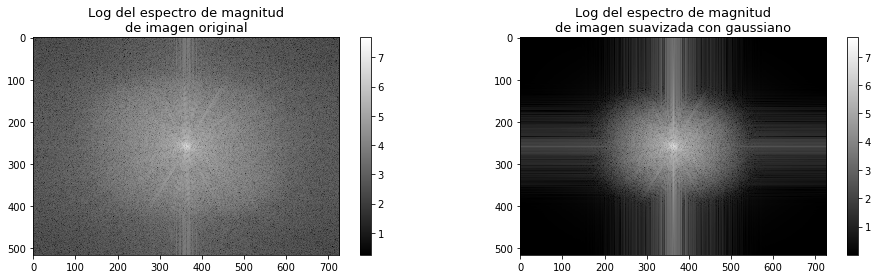

In [13]:
visualizar([img, img_sg], ['suavizada con gaussiano'], frec=True)

***Puede verse como aún cuando se aplica en el dominio espacial la operación está filtrando frecuencias, dejando pasar las bajas y eliminando las altas. Resulta lógico porque las altas están asociadas a las transiciones abruptas, muy típicas de los bordes/ruido que es lo que en el dominio espacial vemos que este filtro está atenuando.***

***
***Aplico filtro laplaciano...***

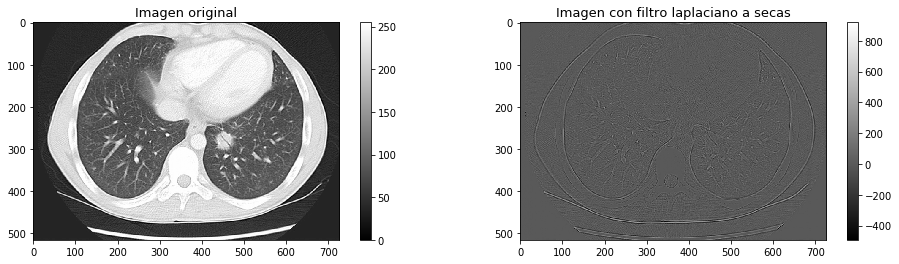

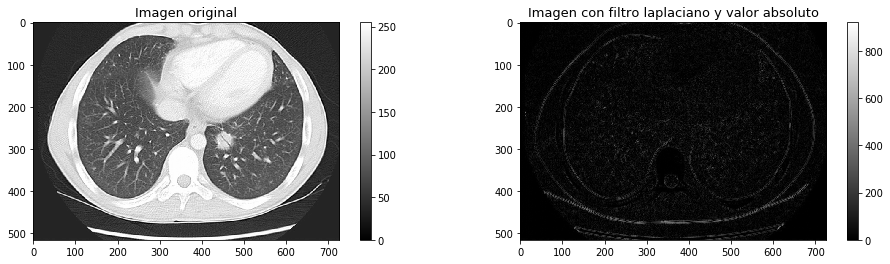

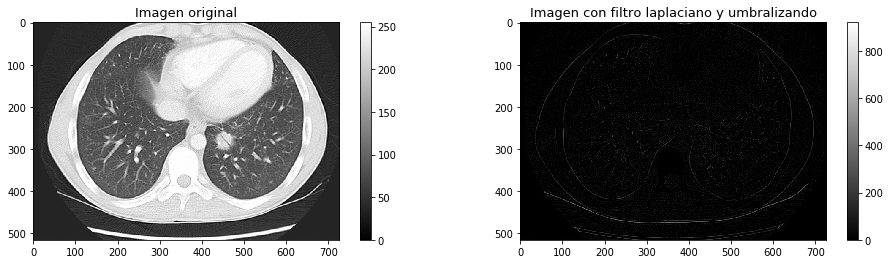

In [14]:
N = 3 # dimensión del filtro

# Filtros con y sindiagonales..
FL = -np.ones((N,N))
FL[(N//2,N//2)] = N**2-1
FL2 = np.zeros((3,3))
FL2[0,1], FL2[1,0], FL2[1,1], FL2[1,2], FL2[2,1] = -1, -1, 4, -1, -1 

# Convoluciono y visualizo sin cambios, con valor absoluto y ubralizando en 0..
img_l = ss.convolve(img, FL, mode='same');
visualizar([img, img_l], ['con filtro laplaciano a secas'])
visualizar([img, abs(img_l)], ['con filtro laplaciano y valor absoluto'])
visualizar([img, np.where(img_l>=0, img_l,0)], ['con filtro laplaciano y umbralizando'])

***Usando una función de `scipy`...***

In [15]:
img_lb = ss.convolve(img, -FL2, mode='same')
img_l2 = si.laplace(img.astype(np.float64), mode='constant')
print('La imagen suavizada es igual: ', np.allclose(img_lb, img_l2, atol=1))

La imagen suavizada es igual:  True


***Miro el espectro...***

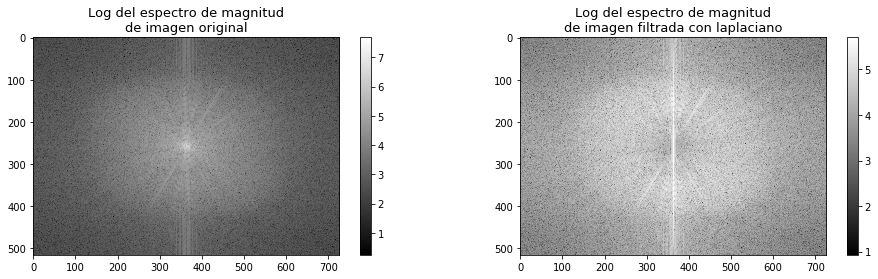

In [16]:
visualizar([img, img_l], ['filtrada con laplaciano'], frec=True)

***En este caso, a diferencia del previo, se observa que las frecuencias más altas de la periferia son las que incrementan su intensidad mientras que las bajas, que ocupan el centro de la visualización, disminuyen.<br><br>
Mirando la diferencia (y dejando en 0 los valores negativos de la misma), se puede ver más claramente las frecuencias que enfatiza el filtro laplaciano...***

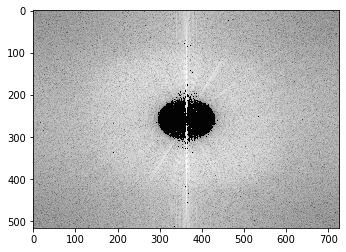

In [17]:
M_dif = mi_fft(img_l) - mi_fft(img)
plt.imshow(np.log(np.where(M_dif>0,M_dif,1)), cmap='gray');

***
***c) Como se habló en clase, una forma de obtener una imagen con los bordes realzados sin perder el resto de la información útil podría ser sumar la imagen original con la que se obtuvo a partir del filtro laplaciano.***

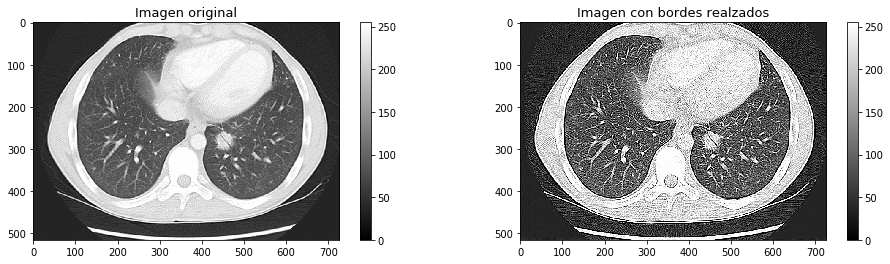

In [18]:
# Primero defino una función para la suma, y una transf lineal a aplicar si no se quiere "clampear" el resultado..
def suma(imgs, modo='contraste', bd=8):
    img_r = 0
    for img in imgs:
        img_r += img.astype(np.float64)
    if modo == 'contraste':
        img_r = contraste(img_r, bd=bd)
    elif modo == 'acumulacion':
        img_r[img_r>255] = 255
        img_r[img_r<0] = 0
    return img_r

def contraste(img, umb_min=None, umb_max=None, dtype=None, bd=None): 
    if umb_min is None: umb_min = img.min() 
    if umb_max is None: umb_max = img.max() 
    if dtype is None: dtype = img.dtype 
    if bd is None: bd = img.nbytes*8/img.size 
    img = np.where(img<umb_min, umb_min, img) 
    img = np.where(img>umb_max, umb_max, img) 
    return (((img - umb_min)/(umb_max - umb_min))*(2**bd-1)).astype(dtype)

img_r = suma([img, img_l], modo='acumulacion')
visualizar([img, img_r], ['con bordes realzados'])

[comment]: http://scipy-lectures.org/advanced/image_processing/auto_examples/plot_sharpen.html
<!-- esto está comentado --> 
<esto es un comentario> 

***
***

# 4.6 Actividad 12

>***a) Abrir una imagen y agréguele ruido gaussaiano, impulsivo y uniforme.<br>
b) Mostrar el resultado de filtrar la imagen con ruido con dos diferentes filtros espaciales (al menos dos, uno no lineal y otro lineal).<br>
c) ¿Cuál de los filtros aplicados parece tener un mejor desempeño para corregir el ruido?***

***Sigo usando la imagen del tórax. Primero le agrego los ruidos. Primero cada ruido por separado, para ver los efectos de cada uno y luego todos juntos...*** 

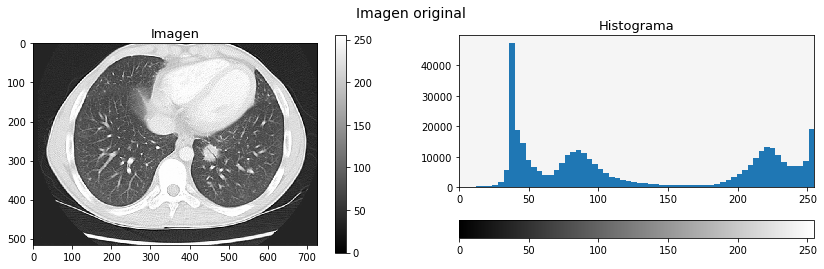

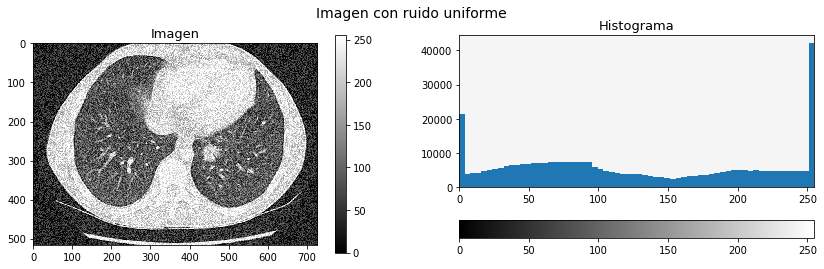

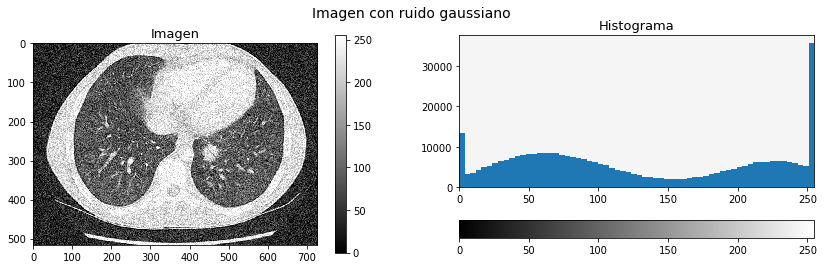

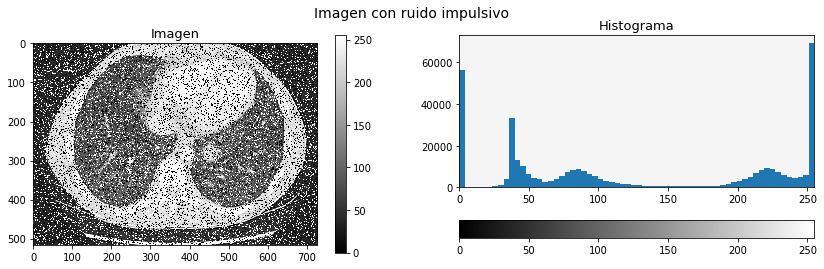

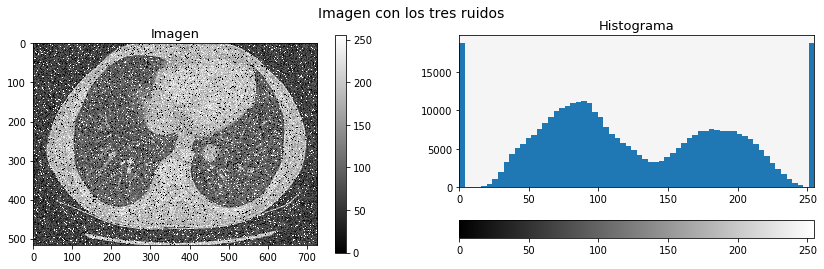

In [19]:
# Para ver los efectos, armo una función para mostrar imagen e histograma..
def visualizar_h(img, bd=8, tit='original', yscale='linear', figsize=(14,4), nrowscols=(1,2), bins=64):
    fig, ax = plt.subplots(*nrowscols, figsize=figsize)
    fig.suptitle('Imagen '+tit, fontsize=14)
    vmin, vmax = [0, (2**bd-1)] if bd is not None else None, None
    cb = ax[0].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    fig.colorbar(cb, ax=ax[0])
    ax[0].set(title='Imagen')
    ax[1].hist(img.ravel(), bins=bins, range=(0,img.max()));
    ax[1].set(xlim=(0, img.max()), yscale=yscale, facecolor='whitesmoke', title='Histograma')
    fig.colorbar(cb, ax=ax[1], orientation='horizontal')
    return fig


# ORIGINAL
visualizar_h(img)

# RUIDO UNIFORME..
a = -60
b = 60
Ru = st.randint(a, b).rvs((img.shape))
img_ru = suma([img, Ru], modo='acumulacion')
visualizar_h(img_ru, tit='con ruido uniforme')

# RUIDO GAUSSIANO..
mu = 0
de = 30
Rn = st.norm(mu, de).rvs(size=(img.shape))
img_rn = suma([img, Rn], modo='acumulacion')
visualizar_h(img_rn, tit='con ruido gaussiano')

# RUIDO IMPULSIVO..
# Función p/incorporar ruido impulsivo a una imagen...
def ruido_syp(img, umb=0.15):
    img_r = img.copy()
    D = st.uniform().rvs(img.shape)
    img_r[D<umb] = 0
    img_r[D>(1-umb)] = 255
    return img_r.astype(np.float64)

img_ri = ruido_syp(img)
visualizar_h(img_ri, tit='con ruido impulsivo')

# COMBINACIÓN DE TODOS LOS RUIDOS
img_rt =  ruido_syp(suma([img, 0.9*Ru, 0.3*Rn]), umb=0.05)
visualizar_h(img_rt, tit='con los tres ruidos');

***Para ver el efecto de distintos filtrados en CADA ruido, aplico filtrado con promedio simple (lineal) y mediana (no lineal) a los distintos tipos de ruido. Por cuestión de espacio, no incluyo el mapa de colores que es para todos el mismo 0-255...***

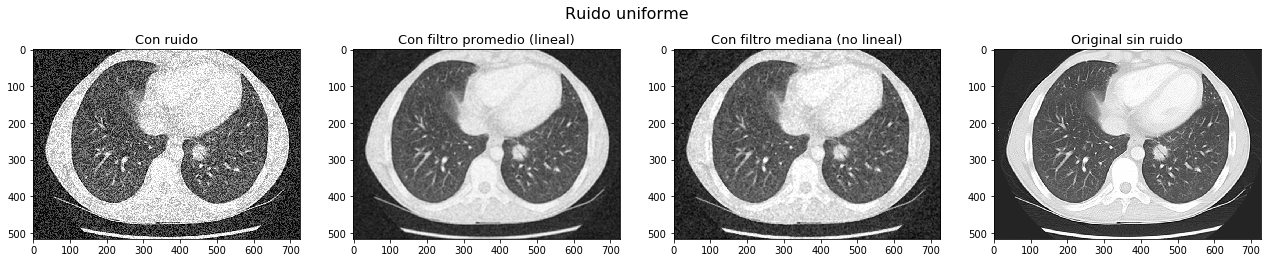

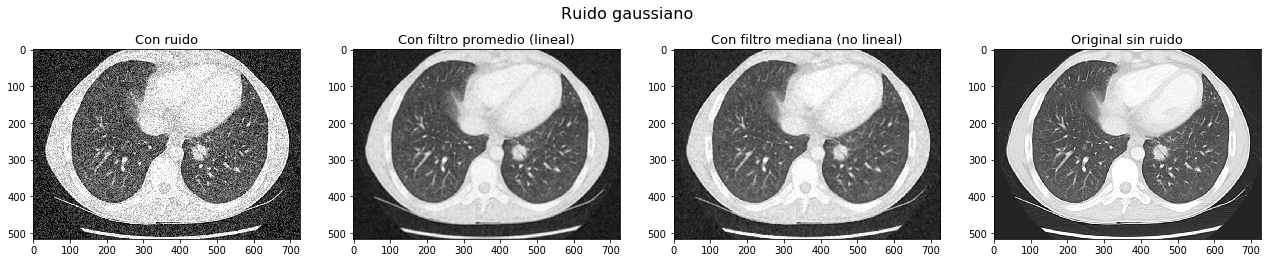

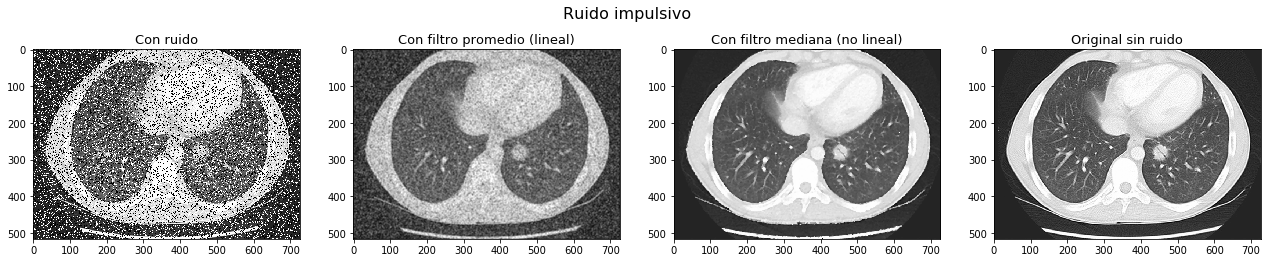

In [20]:
N = 5
im_ruidos = [img_ru, img_rn, img_ri]
titulos = ['uniforme', 'gaussiano', 'impulsivo']
for im_ruido, titulo in zip(im_ruidos, titulos):
    fig, ax = plt.subplots(1, 4, figsize=(22,4), gridspec_kw={'hspace':0})
    fig.suptitle('Ruido '+ titulo, fontsize=16)
    ax[0].imshow(im_ruido, cmap='gray')
    ax[0].set_title('Con ruido')
    _img_fl = si.uniform_filter(im_ruido, N, mode='constant')
    ax[1].imshow(_img_fl, cmap='gray')
    ax[1].set_title('Con filtro promedio (lineal)')
    _img_fnl = ss.medfilt(im_ruido, N)
    ax[2].imshow(_img_fnl, cmap='gray')
    ax[2].set_title('Con filtro mediana (no lineal)')
    ax[3].imshow(img, cmap='gray')
    ax[3].set_title('Original sin ruido')

***Se observa que mientras el filtro lineal es mejor para reducir los efectos de los ruidos gaussiano y (sobre todo) uniforme, el ruido impulsivo es tratado con mucho mejor resultado por el filtro mediana, que prácticamente lo elimina.<br>
<br>
Para ver el efecto de utilizar kernel de distinta dimensión, a continación aplico filtro promedio y mediana a ruidos uniforme e impuslivo, respectivamente, con tamaños de kernel crecientes.***

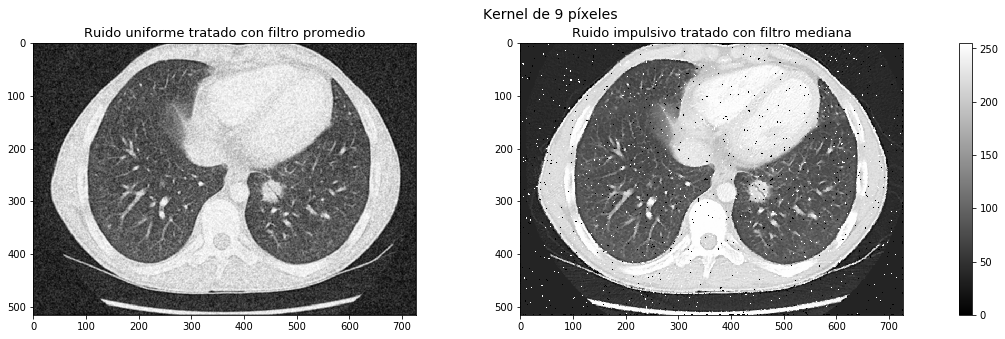

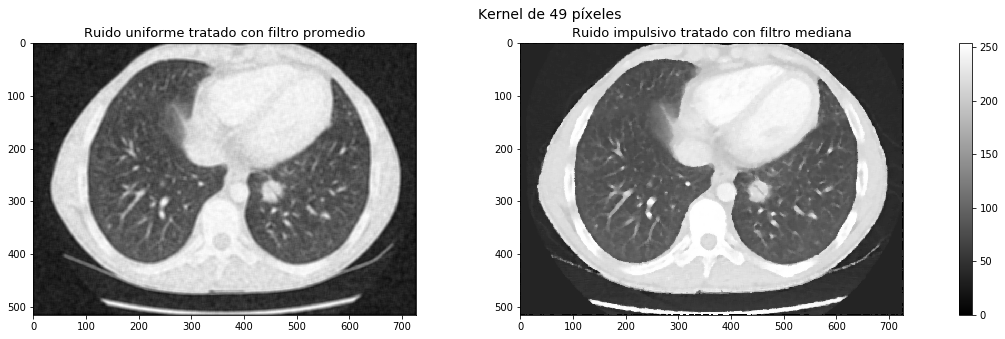

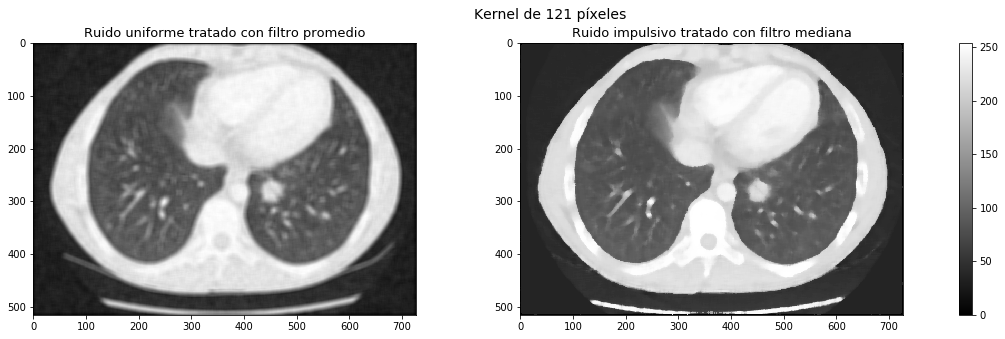

In [21]:
for N in [3, 7, 11]:
    fig, ax = plt.subplots(1,2,figsize=(20,5), gridspec_kw={'hspace':0})
    fig.suptitle('Kernel de {} píxeles'.format(N**2), fontsize=14)
    _img_fl = si.uniform_filter(img_ru, N, mode='constant')
    cb = ax[0].imshow(_img_fl, cmap='gray')
    ax[0].set_title('Ruido uniforme tratado con filtro promedio')
    _img_fnl = ss.medfilt(img_ri, N)
    cb = ax[1].imshow(_img_fnl, cmap='gray')
    ax[1].set_title('Ruido impulsivo tratado con filtro mediana')
    fig.colorbar(cb, ax=ax)

***Se observa que a medida que se incrementa el tamaño del kernel, la eliminación del ruido es mayor, pero la imagen pierde cada vez más nitidez, resultando en una relación de compromiso que hay que sopesar en cada caso.<br>
<br>
En el caso particular de la imagen con ruido impulsivo es notorio cómo el kernel de 25 píxeles tiene un desempeño notoriamente mejor que el de 9, pero de seguir incrementando tamaño implica pérdida de detalles sin mejora adicional. De cualquier modo, es solo para ejemplificar. Muy probablemente, en este caso la mejor estrategia sea reiterar el filtrado con el kernel más pequeño, saliendo en parte del tradeoff y logrando eliminar más ruido que con una pasada, sin incrementar mucho la pérdida de detalle, como se muestra a continuación...*** 

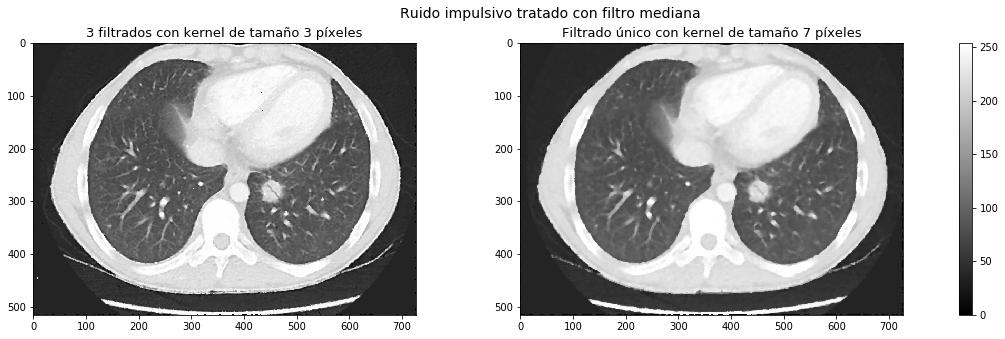

In [23]:
N_A, N_B = 3, 7
n = 3
fig, ax = plt.subplots(1,2, figsize=(20,5), gridspec_kw={'hspace':0})
fig.suptitle('Ruido impulsivo tratado con filtro mediana', fontsize=14)
_img_fnl_A = img_ri.copy()
for i in range(n):
    _img_fnl_A = ss.medfilt(_img_fnl_A, N_A)
cb = ax[0].imshow(_img_fnl_A, cmap='gray')
ax[0].set_title('{} filtrados con kernel de tamaño {} píxeles'.format(n, N_A))    
_img_fnl_B = ss.medfilt(img_ri, N_B)
cb = ax[1].imshow(_img_fnl_B, cmap='gray')
ax[1].set_title('Filtrado único con kernel de tamaño {} píxeles'.format(N_B))
fig.colorbar(cb, ax=ax);

***Por último, el resultado de tratar la imagen afectada por la combinación de ruidos, con distintos filtrados...*** 

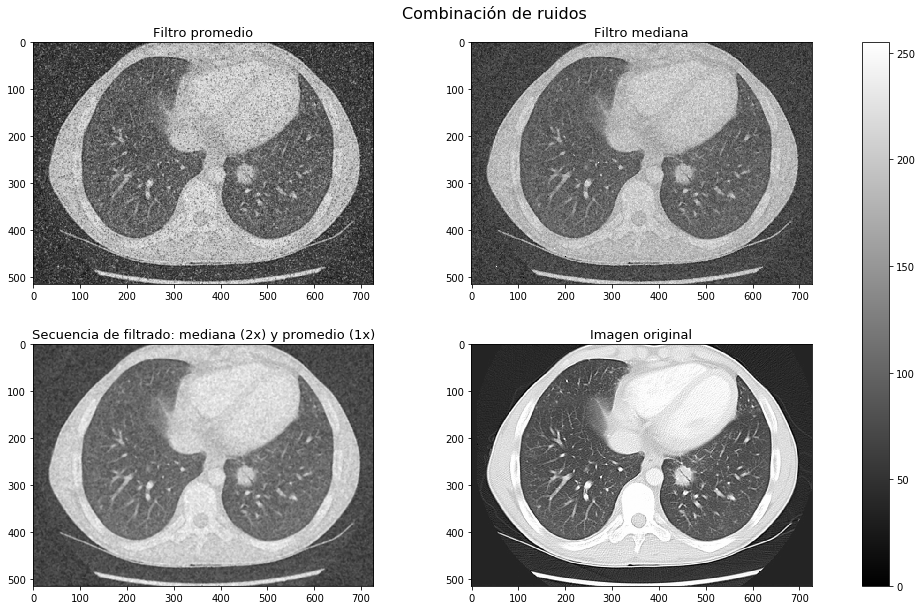

In [24]:
N,n = 3,3
fig, ax = plt.subplots(2,2,figsize=(18,10), gridspec_kw={'hspace':0.25})
ax = ax.flat
fig.suptitle('Combinación de ruidos', fontsize=16, y=0.93)

# Filtrado lineal
_img_fl = si.uniform_filter(img_rt, N, mode='constant')
cb = ax[0].imshow(contraste(_img_fl, bd=8), cmap='gray')
ax[0].set_title('Filtro promedio')

# Filtrado no lineal
_img_fnl = ss.medfilt(img_rt, N)
ax[1].imshow(contraste(_img_fnl, bd=8), cmap='gray')
ax[1].set_title('Filtro mediana')

# Filtrado combinado
_img_fc = img_rt.copy()
for i in range(2):
    _img_fc = ss.medfilt(_img_fc, N)
_img_fc = si.uniform_filter(_img_fc, N, mode='constant')
ax[2].imshow(contraste(_img_fc, bd=8), cmap='gray')
ax[2].set_title('Secuencia de filtrado: mediana (2x) y promedio (1x)')

# Imagen original
ax[3].imshow(contraste(img, bd=8), cmap='gray')
ax[3].set_title('Imagen original')

fig.colorbar(cb, ax=ax);

***
***
<h1 style="color:green;font-size:50px;"><center>FIN!</center></h1>

***
***
***